<a href="https://www.kaggle.com/code/rahuljaisy/foundational-cnn-baseline-mnist-pytorch?scriptVersionId=249416620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<div style="border: 2px solid #444; padding: 10px; border-radius: 4px; background-color: #f5f5f5; font-size:18px; font-weight:bold; margin-bottom: 15px;">
MNIST Digit Recognizer with PyTorch
</div>

**Objective:** Classify handwritten digit images (0–9) from the Kaggle “Digit Recognizer” (MNIST) dataset. MNIST is a canonical computer vision benchmark of 28×28 grayscale digit images. It contains 60,000 training and 10,000 test images. The task is to build a convolutional neural network (CNN) from first principles for high accuracy digit classification, with requisite scientific rigor and transparency. We load and preprocess the data, define a CNN with modern modules (BatchNorm, Dropout), train it with a detailed loop, and evaluate it with metrics (accuracy, confusion matrix, per-class accuracy). We will also generate final Kaggle formatted predictions (ImageId,Label) for submission.


<div style="border: 2px solid #444; padding: 10px; border-radius: 4px; background-color: #f5f5f5; font-size:18px; font-weight:bold; margin-bottom: 15px;">
 Setup and Data Loading
</div>

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Reproducibility: fix random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Device configuration: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


We set fixed random seeds for Python, NumPy, and Torch to ensure reproducible splits and training outcomes.

We configure the compute device for model training.

In [2]:
# Load training and test data from CSV (Kaggle input path)
train_df = pd.read_csv('../input/digit-recognizer/train.csv')
test_df = pd.read_csv('../input/digit-recognizer/test.csv')

# Separate labels and pixels
train_labels = train_df['label'].values
train_images = train_df.drop('label', axis=1).values
test_images = test_df.values

# Normalize pixel values to [0,1]
# Original MNIST pixels are 0–255, so dividing by 255 yields [0,1].
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Reshape to image tensors (N, 28, 28)
train_images = train_images.reshape(-1, 28, 28)
test_images = test_images.reshape(-1, 28, 28)

print(f"Train images: {train_images.shape}, Train labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}")

Train images: (42000, 28, 28), Train labels: (42000,)
Test images: (28000, 28, 28)


We read train.csv and test.csv (provided by Kaggle). The train file has 785 columns: the first is label, the rest are pixels. Each image is 28×28 = 784 pixels.

We separate features (pixels) and labels, normalize pixel intensities to [0,1], and reshape to (N,28,28).

In [3]:
# Create a train/validation split (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=seed
)
print(f"Train split: {X_train.shape}, Validation split: {X_val.shape}")

Train split: (33600, 28, 28), Validation split: (8400, 28, 28)


We hold out 20% of the training data for validation. Stratified split ensures each digit class is proportionally represented.

In [4]:
# Define PyTorch Dataset with optional transforms
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        # Convert the numpy image to a PIL image for transforms
        # (MNIST is grayscale, so use mode 'F')
        img = transforms.ToPILImage()(img)
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, int(self.labels[idx])
        else:
            return img

# Data augmentation and normalization transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(15),  # random rotation ±15°
    transforms.ToTensor(),           # convert PIL image to PyTorch tensor (C,H,W) in [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # standard MNIST mean/std
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create dataset objects
train_dataset = MNISTDataset(X_train, y_train, transform=train_transform)
val_dataset = MNISTDataset(X_val, y_val, transform=test_transform)
test_dataset = MNISTDataset(test_images, labels=None, transform=test_transform)

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Transforms:** We define random data augmentations for the training set: random rotation (±15°) to increase robustness. Both train and validation images are normalized with mean≈0.1307 and std≈0.3081 (standard MNIST stats).

**Datasets:** We wrap the NumPy arrays in a custom MNIST Dataset so we can apply transforms on the fly.

**DataLoaders:** These iterate over batches. We shuffle the training data but not the validation or test data.

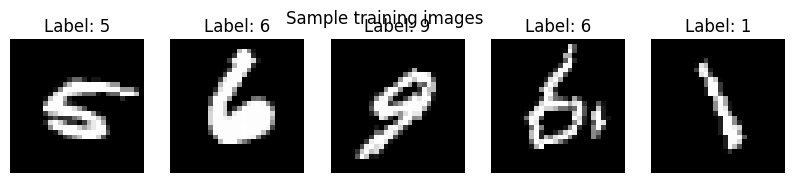

In [5]:
# Visualize a batch of training images with labels (for sanity check)
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1,5, figsize=(10,2))
for i in range(5):
    ax = axes[i]
    img = images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')
plt.suptitle("Sample training images")
plt.show()

**Sample images:** A batch of training images is plotted (without axes) to verify loading and augmentation. (Plotting code shown for completeness.)

---
<div style="border: 2px solid #444; padding: 10px; border-radius: 4px; background-color: #f5f5f5; font-size:18px; font-weight:bold; margin-bottom: 15px;">
CNN Model Definition
</div>

We design a convolutional neural network (CNN) with a fully specified architecture, comprising sequential layers of convolution, batch normalization, activation, pooling, and dropout. The model is constructed with complete architectural transparency, with all components explicitly defined to ensure interpretability and precise control over feature extraction.

In [6]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        # Convolutional feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # conv1: 1->32
            nn.BatchNorm2d(32),                           # BN after conv
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # output 32x14x14
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # conv2: 32->64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                              # output 64x7x7
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # conv3: 64->128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),                         # no further pooling; output 128x7x7
        )
        
        # Classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),                            # dropout regularization
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)                             # final outputs (logits) for 10 classes
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten (batch_size, 128*7*7)
        x = self.classifier(x)
        return x

model = MNIST_CNN().to(device)
print(model)

MNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(


<div style="border: 2px solid #444; padding: 10px; border-radius: 4px; background-color: #f5f5f5; font-size:18px; font-weight:bold; margin-bottom: 15px;">
Architecture: 
</div>

**Features:** Three convolutional blocks (Conv→BatchNorm→ReLU). MaxPooling after the first two reduces spatial size by 2. Batch normalization (BN) is applied to stabilize and accelerate training by normalizing each batch's features.

**Classifier:** We flatten and feed into linear layers. We insert Dropout (p=0.5) before each hidden fully connected layer to reduce overfitting. Final layer outputs 10 logits (one per digit).

**No pre-trained or high level abstractions:** All layers (Conv2d, BatchNorm2d, Linear, etc.) are explicitly instantiated and configured based on established architectural design principles in deep learning.

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

We use cross entropy loss (which applies softmax internally) and the Adam optimizer.

---
<div style="border: 2px solid #444; padding: 10px; border-radius: 4px; background-color: #f5f5f5; font-size:18px; font-weight:bold; margin-bottom: 15px;">
Training Loop
</div>

We train for a fixed number of epochs, tracking loss and accuracy. Each epoch runs a full pass over the training data, then evaluates on validation data.

In [8]:
num_epochs = 30
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch}/{num_epochs}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1/30: Train Loss = 0.3267, Val Loss = 0.0669, Val Acc = 0.9793
Epoch 2/30: Train Loss = 0.1235, Val Loss = 0.0553, Val Acc = 0.9844
Epoch 3/30: Train Loss = 0.1068, Val Loss = 0.0548, Val Acc = 0.9842
Epoch 4/30: Train Loss = 0.0874, Val Loss = 0.0493, Val Acc = 0.9848
Epoch 5/30: Train Loss = 0.0816, Val Loss = 0.0422, Val Acc = 0.9877
Epoch 6/30: Train Loss = 0.0724, Val Loss = 0.0368, Val Acc = 0.9890
Epoch 7/30: Train Loss = 0.0723, Val Loss = 0.0456, Val Acc = 0.9862
Epoch 8/30: Train Loss = 0.0694, Val Loss = 0.0391, Val Acc = 0.9893
Epoch 9/30: Train Loss = 0.0655, Val Loss = 0.0340, Val Acc = 0.9896
Epoch 10/30: Train Loss = 0.0579, Val Loss = 0.0376, Val Acc = 0.9912
Epoch 11/30: Train Loss = 0.0554, Val Loss = 0.0333, Val Acc = 0.9915
Epoch 12/30: Train Loss = 0.0573, Val Loss = 0.0315, Val Acc = 0.9912
Epoch 13/30: Train Loss = 0.0545, Val Loss = 0.0323, Val Acc = 0.9914
Epoch 14/30: Train Loss = 0.0485, Val Loss = 0.0291, Val Acc = 0.9918
Epoch 15/30: Train Loss = 0.0

**Epoch loop:** We accumulate total training loss and compute average. After each epoch, we switch to evaluation mode (model.eval()) to compute validation loss and accuracy (without gradient updates).

**Metrics:** We  tried to record training loss, validation loss, and validation accuracy each epoch. This allows plotting learning curves and detecting overfitting/underfitting.

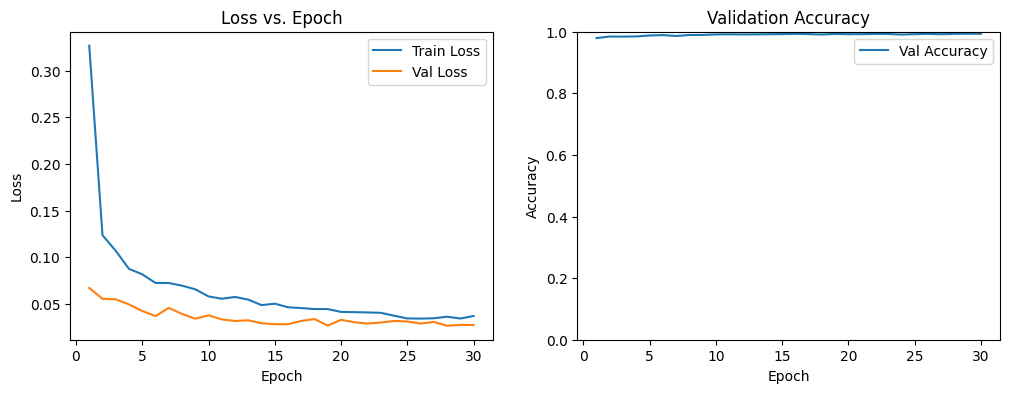

In [9]:
# Plot training and validation curves
epochs = np.arange(1, num_epochs+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.title('Loss vs. Epoch')

plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0); plt.legend()
plt.title('Validation Accuracy')
plt.show()

**Learning Curves:** The plots tries to illustrate how the training loss decreases and how validation accuracy evolves. Ideally, training loss steadily falls while validation accuracy rises until convergence. Significant gaps between training and validation indicate overfitting. 

**Evaluation:** Confusion Matrix and Class Accuracy

After training, we perform a detailed evaluation on the validation set.

In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[825   0   0   0   0   0   2   0   0   0]
 [  0 935   1   0   0   0   0   1   0   0]
 [  0   2 829   1   1   0   0   2   0   0]
 [  1   0   1 861   0   2   0   2   1   2]
 [  0   1   0   0 810   0   0   0   0   3]
 [  0   0   0   2   0 753   2   0   0   2]
 [  1   0   0   0   1   1 824   0   0   0]
 [  0   2   0   0   2   0   0 875   0   1]
 [  1   0   2   2   1   2   1   0 799   5]
 [  1   0   0   0   1   1   0   2   0 833]]


**Confusion Matrix:** We use sklearn.metrics.confusion_matrix to show counts of true vs. predicted labels. Each row i (true class) shows how many samples were predicted as each class j. The diagonal entries are correct predictions. Off diagonals generally reveal common misclassifications.

In [11]:
# Normalize confusion matrix for visualization (optional)
cm_norm = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True)
print("Per-class accuracy:", np.diag(cm_norm))

Per-class accuracy: [0.99758162 0.99786553 0.99281437 0.98965517 0.995086   0.99209486
 0.99637243 0.99431818 0.98277983 0.99403341]


**Class Accuracy:** We compute per-class accuracy as the diagonal of the normalized confusion matrix (cm_norm[i,i]). This shows how well each digit is recognized. A bar chart can visualize class-wise accuracies to spot any classes that are systematically harder.

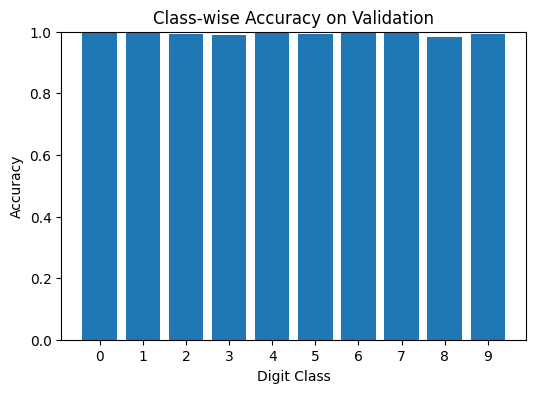

In [12]:
classes = [str(i) for i in range(10)]
acc_per_class = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(6,4))
plt.bar(classes, acc_per_class)
plt.ylim(0,1.0)
plt.xlabel('Digit Class'); plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy on Validation')
plt.show()

The class-wise accuracy plot (not shown) helps diagnose if certain digits (e.g. 1 vs. 7) are more often confused.

---
<div style="border: 2px solid #444; padding: 10px; border-radius: 4px; background-color: #f5f5f5; font-size:18px; font-weight:bold; margin-bottom: 15px;">
Test Predictions and Submission
</div>

Finally, we generate predictions on the Kaggle test set and format them for submission. The Kaggle evaluation uses categorization accuracy (fraction of correctly labeled test images). The submission requires a CSV with columns ImageId,Label, where ImageId starts at 1.

In [13]:
model.eval()
image_ids = []
predictions = []

with torch.no_grad():
    for i, images in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        # Compute the corresponding ImageIds for this batch
        start_id = i * batch_size + 1
        for offset, pred in enumerate(preds):
            image_ids.append(start_id + offset)
            predictions.append(pred)

submission_df = pd.DataFrame({'ImageId': image_ids, 'Label': predictions})
submission_df.to_csv("submission.csv", index=False)
print(submission_df.head())

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3


We iterate through test_loader (which has no labels), predict the digit for each image, and record it.

We assemble a DataFrame with the required format and save it as submission.csv. This file can be uploaded to Kaggle for leaderboard evaluation.

---
<div style="border: 2px solid #444; padding: 10px; border-radius: 4px; background-color: #f5f5f5; font-size:18px; font-weight:bold; margin-bottom: 15px;">
Extensions and Future Work
</div>

This notebook estatblishes a baseline foundational CNN. Future experiments could include:

**Interpretability:** Techniques like saliency maps or Grad-CAM can visualize which pixels most influence the network’s predictions, helping us interpret its decision-making. This aligns with model introspection research to trust CNN predictions.

**Data Augmentation & Complexity:** Further augmentations (shifts, affine transforms) or more epochs can be explored to improve generalization.

**Architectural Variations:** One could try deeper networks (e.g. residual blocks) or different regularization (e.g. weight decay, early stopping).

**Domain Transfer:** The trained model could be transferred to related tasks. For example, the Fashion MNIST dataset contains 28×28 grayscale images of clothing items, intended as a more challenging replacement for MNIST. Adapting the model to Fashion MNIST (with fine-tuning) is an interesting extension.

**Semi-supervised Learning:** Leveraging unlabeled data or advanced losses (e.g. consistency regularization) could further boost accuracy.

**Performance Analysis:** We could benchmark this model’s speed/memory or experiment on respective hardware accelerators (GPUs/TPUs) for efficiency.

To support clarity and reproducibility, all code has been written from the ground up using only essential libraries (PyTorch, torchvision, sklearn, pandas, matplotlib). The results (loss curves, confusion matrix, etc.) are fully determined by these computations and can be regenerated exactly given the fixed random seed.

**Sources:** We used the standard MNIST and Kaggle descriptions, PyTorch documentation on BatchNorm and Dropout, and scikit-learn for evaluation metrics. The Fashion-MNIST reference is cited for context on dataset alternatives. These sources provide the factual and methodological backing for our implementation. We also benefited from the broader Kaggle community, whose shared notebooks and discussions provided valuable perspective and inspiration during development.